# Dgemm trace of a real and complete HPL run

In [1]:
import io
import os
import zipfile
import pandas
import yaml
import datetime
import re
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore') # removing annoying warning
import json

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x, usecols=None):
    archive = zipfile.ZipFile(archive_name)
    df = pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    df['jobid'] = int(get_yaml(archive_name, 'info.yaml')['jobid'])
    return df

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

def get_json(archive_name, json_name):
    archive = zipfile.ZipFile(archive_name)
    return json.load(io.BytesIO(archive.read(json_name)))

In [2]:
def __compute_rank_mapping(archive_name, exp_id):
    '''
    Compute the mapping rank-core, based on mpirun output (thanks to the option --report-bindings).
    '''
    history = get_json(archive_name, 'history.json')
    mpirun = [cmd for cmd in history if cmd['command'].startswith('mpirun') and len(cmd['hostnames']) == 1]
    mpirun = mpirun[exp_id]['stderr'].split('\n')
    regex = re.compile('\[(?P<hostname>[a-z]+-\d+\.[a-z]+\.grid5000\.fr):\d+\] MCW rank (?P<rank>\d+) bound to socket (?P<socket>\d+)\[core (?P<core>\d+)')
    mapping = []
    for line in mpirun:
        match = regex.search(line)
        if match:
            mapping.append({'rank': int(match.group('rank')),
                            'hostname': match.group('hostname'),
                            'socket': int(match.group('socket')),
                            'core': int(match.group('core'))
                           })
    df = pandas.DataFrame(mapping)[['rank', 'hostname', 'socket', 'core']]
    df['node'] = df['hostname'].str[len('dahu-'):-len('.grenoble.grid5000.fr')].astype(int)
    df['cpu'] = df['node']*2 + df['socket'] - 2
    return df.sort_values(by='rank').reset_index(drop=True)

def compute_rank_mapping(archive_name):
    nb_exp = len(read_csv(archive_name, get_yaml(archive_name, 'info.yaml')['expfile'][0]))
    mappings = [__compute_rank_mapping(archive_name, i) for i in range(nb_exp)]
    ref = mappings[0]
    for df in mappings[1:]:
        assert ref.equals(df)
    return ref

In [3]:
archive = 'dgemm_prediction/11/grenoble_2019-12-10_1896889.zip'

def __read_archive(archive_name, exp_id):
    blas_col = ['file', 'line', 'function', 'rank', 'timestamp', 'duration', 'm', 'n', 'k']
    df = read_csv(archive_name, 'trace_blas_%d.csv' % exp_id, columns=blas_col)
    print('Read trace n°%d from %s: %6d lines' % (exp_id, archive_name, len(df)))
    df['start'] = df.timestamp
    df['end'] = df.timestamp + df.duration
    df = df[['jobid', 'function', 'start', 'end', 'rank', 'm', 'n', 'k', 'duration']]
    df['rank+1'] = df['rank'] + 1
    df['function'] = df['function'].str.strip()
    df['exp_id'] = exp_id
    df['block_size'] = read_csv(archive_name, get_yaml(archive_name, 'info.yaml')['expfile'][0]).iloc[exp_id].block_size
    mapping = compute_rank_mapping(archive_name)
    df = df.set_index('rank').join(mapping.set_index('rank')).reset_index()
    return df

def read_archive(archive_name):
    nb_exp = len(read_csv(archive_name, get_yaml(archive_name, 'info.yaml')['expfile'][0]))
    return pandas.concat([__read_archive(archive_name, i) for i in range(nb_exp)])

traces = read_archive(archive)

traces = traces[traces['function'] == 'dgemm']
traces.head()

Read trace n°0 from dgemm_prediction/11/grenoble_2019-12-10_1896889.zip: 8414583 lines
Read trace n°1 from dgemm_prediction/11/grenoble_2019-12-10_1896889.zip: 5333381 lines
Read trace n°2 from dgemm_prediction/11/grenoble_2019-12-10_1896889.zip: 4075397 lines


,rank,jobid,function,start,end,m,n,k,duration,rank+1,exp_id,block_size,hostname,socket,core,node,cpu
1,0,1896889,dgemm,0.177740,0.177783,6270.0,2.0,2.0,0.000043,1,0,128,dahu-17.grenoble.grid5000.fr,0,0,17,32
2,0,1896889,dgemm,0.177873,0.177926,6268.0,4.0,4.0,0.000053,1,0,128,dahu-17.grenoble.grid5000.fr,0,0,17,32
3,0,1896889,dgemm,0.178001,0.178021,6266.0,2.0,2.0,0.000020,1,0,128,dahu-17.grenoble.grid5000.fr,0,0,17,32
4,0,1896889,dgemm,0.178089,0.178203,6264.0,8.0,8.0,0.000114,1,0,128,dahu-17.grenoble.grid5000.fr,0,0,17,32
5,0,1896889,dgemm,0.178281,0.178302,6262.0,2.0,2.0,0.000021,1,0,128,dahu-17.grenoble.grid5000.fr,0,0,17,32


In [4]:
traces[['jobid', 'hostname', 'node']].drop_duplicates().sort_values(by=['jobid', 'node']).reset_index(drop=True)

,jobid,hostname,node
0,1896889,dahu-17.grenoble.grid5000.fr,17
1,1896889,dahu-18.grenoble.grid5000.fr,18
2,1896889,dahu-19.grenoble.grid5000.fr,19
3,1896889,dahu-20.grenoble.grid5000.fr,20
4,1896889,dahu-21.grenoble.grid5000.fr,21
5,1896889,dahu-22.grenoble.grid5000.fr,22
6,1896889,dahu-23.grenoble.grid5000.fr,23
7,1896889,dahu-24.grenoble.grid5000.fr,24
8,1896889,dahu-25.grenoble.grid5000.fr,25
9,1896889,dahu-26.grenoble.grid5000.fr,26


## HPL result

In [5]:
res = read_csv(archive, 'results.csv')
res[['jobid', 'matrix_size', 'block_size', 'time']].sort_values(by='matrix_size')

,jobid,matrix_size,block_size,time
0,1896889,200000,128,444.73
1,1896889,200000,256,490.84
2,1896889,200000,512,549.55


## Checking the parameters

In [6]:
read_csv(archive, 'exp.csv')

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,process_per_node,thread_per_process,jobid
0,200000,128,32,16,1,2,2,1,0,8,32,1,1896889
1,200000,256,32,16,1,2,2,1,0,8,32,1,1896889
2,200000,512,32,16,1,2,2,1,0,8,32,1,1896889


## Prediction error on the duration

In [7]:
stat_file = '/tmp/stats.csv'
!wget https://gitlab.in2p3.fr/tom.cornebize/g5k_data/raw/master/stats.csv -O {stat_file}
stats = pandas.read_csv(stat_file)
min_epoch = int(datetime.datetime.timestamp(datetime.datetime(2019, 12, 5)))
max_epoch = int(datetime.datetime.timestamp(datetime.datetime(2019, 12, 6)))
stats = stats[(stats['start_time'] > min_epoch) & (stats['start_time'] < max_epoch) & (stats['cluster'] == 'dahu')]
stats['cpu'] = stats['node']*2 + stats['cpu'] - 2
print(len(stats))
stats.head()

--2019-12-10 14:05:14--  https://gitlab.in2p3.fr/tom.cornebize/g5k_data/raw/master/stats.csv
Résolution de gitlab.in2p3.fr (gitlab.in2p3.fr)… 134.158.69.41
Connexion à gitlab.in2p3.fr (gitlab.in2p3.fr)|134.158.69.41|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 13544216 (13M) [text/plain]
Sauvegarde en : « /tmp/stats.csv »

/tmp/stats.csv      100%[===================>]  12,92M  25,9MB/s    ds 0,5s    

2019-12-10 14:05:15 (25,9 MB/s) — « /tmp/stats.csv » sauvegardé [13544216/13544216]

64


,function,cluster,node,cpu,jobid,start_time,expfile_hash,avg_gflops,intercept,intercept_residual,...,nk,nk_residual,tvalue_mk,tvalue_mk_residual,tvalue_mn,tvalue_mn_residual,tvalue_mnk,tvalue_mnk_residual,tvalue_nk,tvalue_nk_residual
31835,dgemm,dahu,1,0,1896493,1575532710,39585f2bdee53c186f101850eb7ab6692aaf890a4ca1dd...,25.434839,0.000002,2.761339e-07,...,3.352578e-09,2.459153e-11,50.285953,3.029964,-4.249716,3.523924,729.333021,29.272573,71.303227,2.724969
31836,dgemm,dahu,1,1,1896493,1575532710,39585f2bdee53c186f101850eb7ab6692aaf890a4ca1dd...,26.764543,0.000002,4.525838e-07,...,3.172788e-09,-9.265855e-12,41.430214,-0.188277,-4.303163,-0.321436,579.638938,28.889620,56.439366,-0.658861
31837,dgemm,dahu,2,2,1896493,1575532710,39585f2bdee53c186f101850eb7ab6692aaf890a4ca1dd...,25.950871,0.000003,3.191650e-07,...,3.438317e-09,2.676981e-11,52.276725,4.358024,-4.161075,0.538022,735.827409,26.084408,75.484595,2.970186
31838,dgemm,dahu,2,3,1896493,1575532710,39585f2bdee53c186f101850eb7ab6692aaf890a4ca1dd...,26.956019,0.000003,5.150578e-07,...,3.309012e-09,4.804710e-11,50.501819,4.838223,-4.976149,2.065395,713.539041,29.040681,73.123164,6.290281
31839,dgemm,dahu,3,4,1896493,1575532710,39585f2bdee53c186f101850eb7ab6692aaf890a4ca1dd...,25.980314,0.000002,2.997121e-07,...,3.283419e-09,6.313358e-11,47.554178,0.350079,-3.064435,0.952406,685.202722,21.930374,67.057324,4.475132


In [8]:
traces['pred'] = 0
traces['mnk'] = traces.m * traces.n * traces.k
traces['mn'] = traces.m * traces.n
traces['mk'] = traces.m * traces.k
traces['nk'] = traces.n * traces.k
for cpu in traces['cpu'].unique():
    reg = stats[stats['cpu'] == cpu]
    assert len(reg) == 1
    reg = list(reg.iterrows())[0][1]
    traces.loc[traces['cpu'] == cpu, 'pred'] += reg['intercept']
    for prod in ['mnk', 'mn', 'mk', 'nk']:
        traces.loc[traces['cpu'] == cpu, 'pred'] += reg[prod] * traces[traces['cpu'] == cpu][prod]

In [9]:
traces['error'] = (traces['pred'] - traces['duration']) / traces['duration']
traces['abs_error'] = traces['error'].abs()
tmp = traces[(traces['abs_error'] > 0.1) & (traces['duration'] > 0.1)]
print(len(tmp))
tmp_nonerror = traces[(traces['abs_error'] < 0.1) & (traces['duration'] > 0.1)].sample(n=len(tmp))
tmp.sort_values(by='abs_error', axis=0, ascending=False).head()

3530


,rank,jobid,function,start,end,m,n,k,duration,rank+1,...,core,node,cpu,pred,mnk,mn,mk,nk,error,abs_error
2033402,256,1896889,dgemm,0.370565,0.474375,6144.0,512.0,512.0,0.103810,257,...,0,25,48,0.130928,1.610613e+09,3145728.0,3145728.0,262144.0,0.261220,0.261220
2040973,257,1896889,dgemm,0.180228,0.286125,6144.0,512.0,512.0,0.105897,258,...,1,25,48,0.130928,1.610613e+09,3145728.0,3145728.0,262144.0,0.236365,0.236365
2033403,256,1896889,dgemm,0.479935,0.586530,6144.0,512.0,512.0,0.106595,257,...,0,25,48,0.130928,1.610613e+09,3145728.0,3145728.0,262144.0,0.228268,0.228268
256,0,1896889,dgemm,0.367500,0.471029,6144.0,512.0,512.0,0.103529,1,...,0,17,32,0.124664,1.610613e+09,3145728.0,3145728.0,262144.0,0.204147,0.204147
265,0,1896889,dgemm,4.102630,4.207072,6144.0,512.0,512.0,0.104442,1,...,0,17,32,0.124664,1.610613e+09,3145728.0,3145728.0,262144.0,0.193626,0.193626


In [10]:
traces[traces.duration > 0.1]['error'].describe()

count    1.019760e+06
mean    -1.280487e-02
std      3.151593e-02
min     -1.878736e-01
25%     -3.785247e-02
50%     -7.855162e-03
75%      7.185818e-03
max      2.612205e-01
Name: error, dtype: float64

In [11]:
melted = tmp.melt(id_vars=['jobid', 'block_size', 'hostname', 'cpu', 'm', 'n', 'k', 'mnk', 'mn', 'mk', 'nk', 'start', 'error'], value_vars=['duration', 'pred'], var_name='kind', value_name='time')
melted_nonerror = tmp_nonerror.melt(id_vars=['jobid', 'block_size', 'hostname', 'cpu', 'm', 'n', 'k', 'mnk', 'mn', 'mk', 'nk', 'start', 'error'], value_vars=['duration', 'pred'], var_name='kind', value_name='time')
melted['gflops'] = 2*melted['mnk'] / melted['time'] * 1e-9
melted_nonerror['gflops'] = 2*melted_nonerror['mnk'] / melted_nonerror['time'] * 1e-9

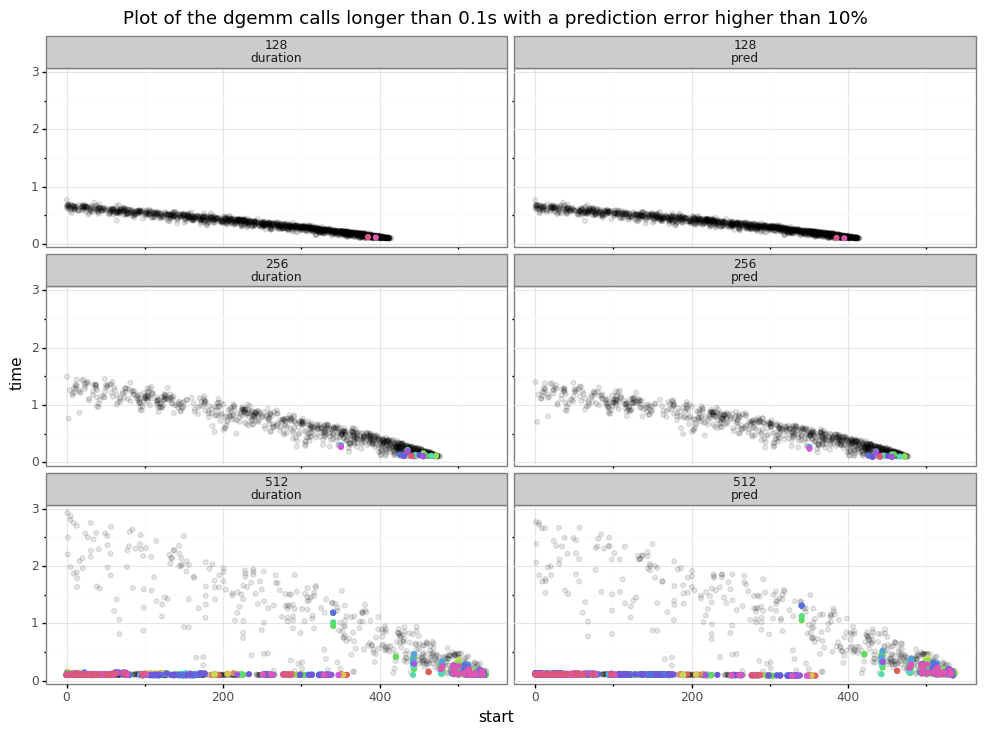

<ggplot: (-9223363274260750448)>


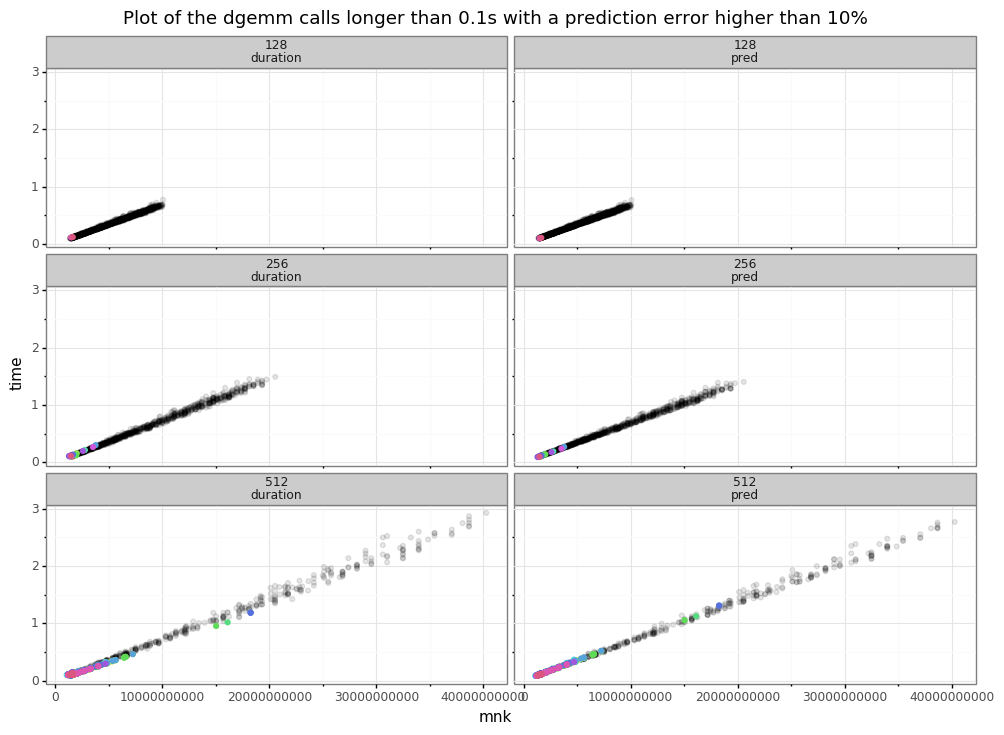

<ggplot: (8762674687047)>


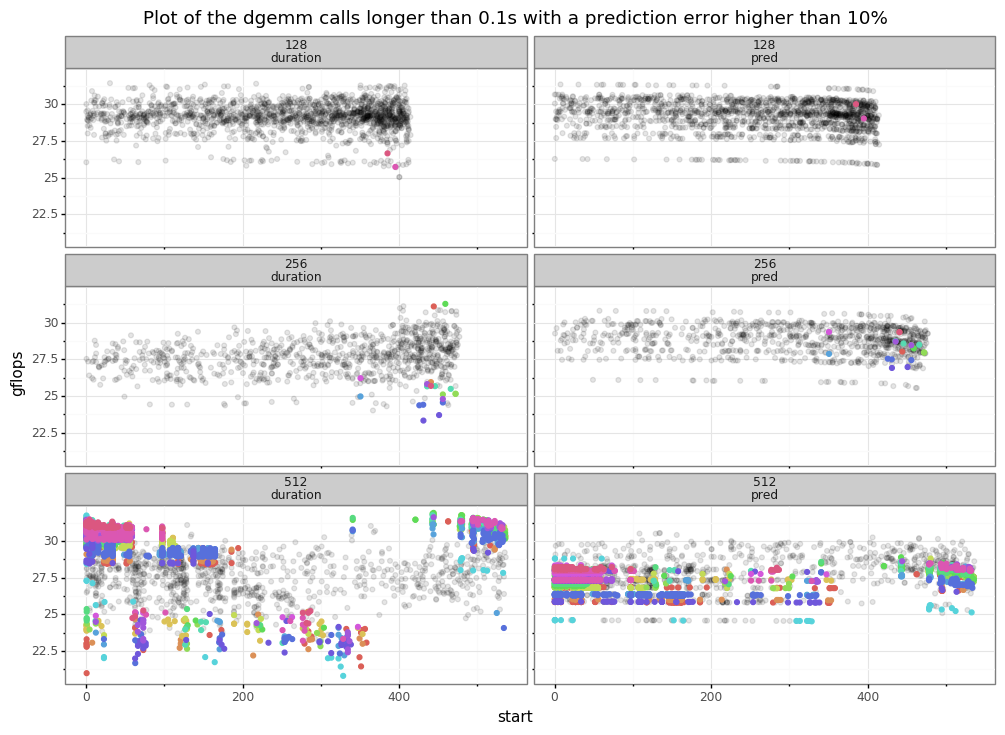

<ggplot: (8762673913678)>


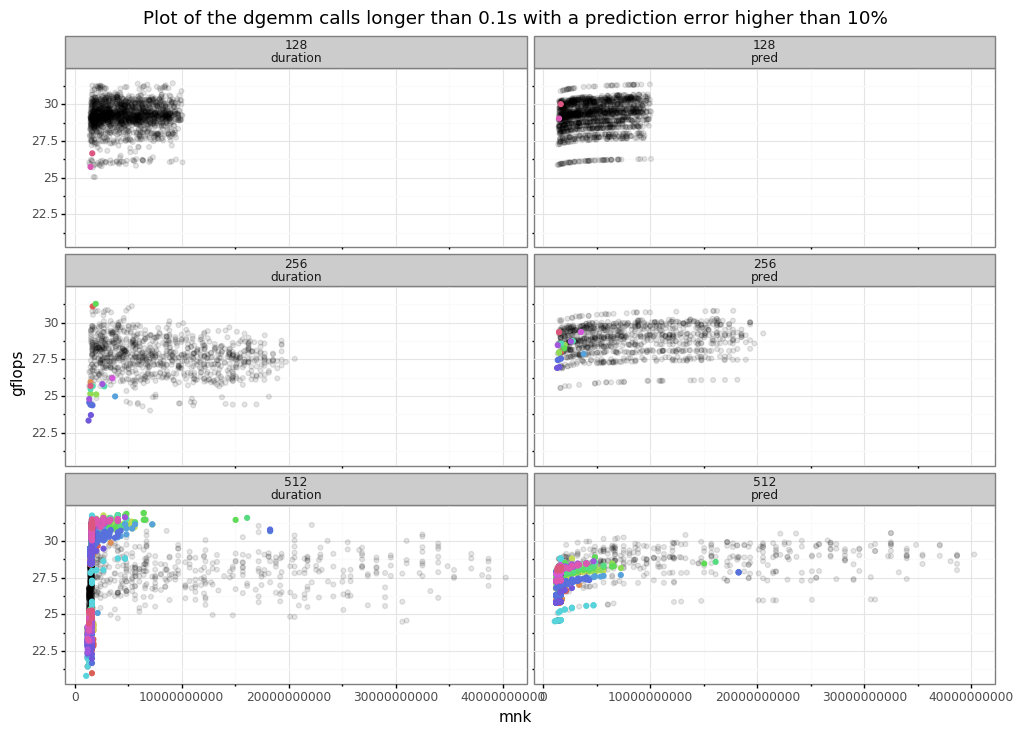

<ggplot: (8762664206235)>


In [12]:
p = ggplot(melted, aes(color='factor(hostname)')) + theme_bw() + facet_wrap(['block_size', 'kind'], ncol=2)
p = p + theme(legend_position='none') + ggtitle('Plot of the dgemm calls longer than 0.1s with a prediction error higher than 10%')
for y in ['time', 'gflops']:
    for x in ['start', 'mnk']:
        print(p + geom_point(melted_nonerror, aes(x=x, y=y), color='black', alpha=0.1) + geom_point(aes(x=x, y=y)))

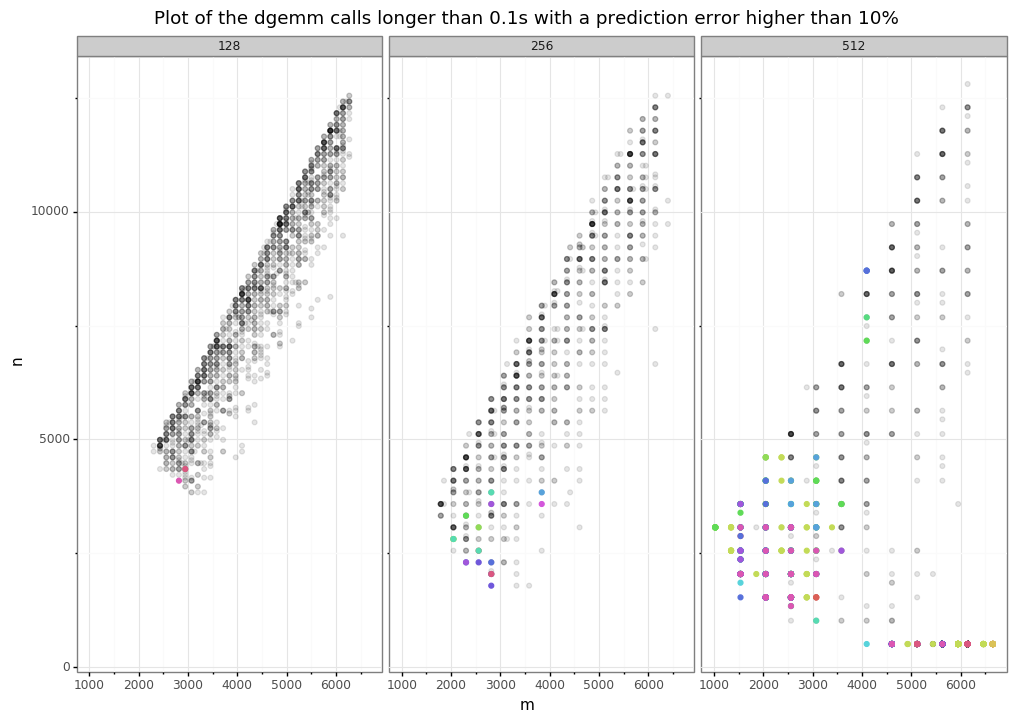

<ggplot: (-9223363274143784893)>


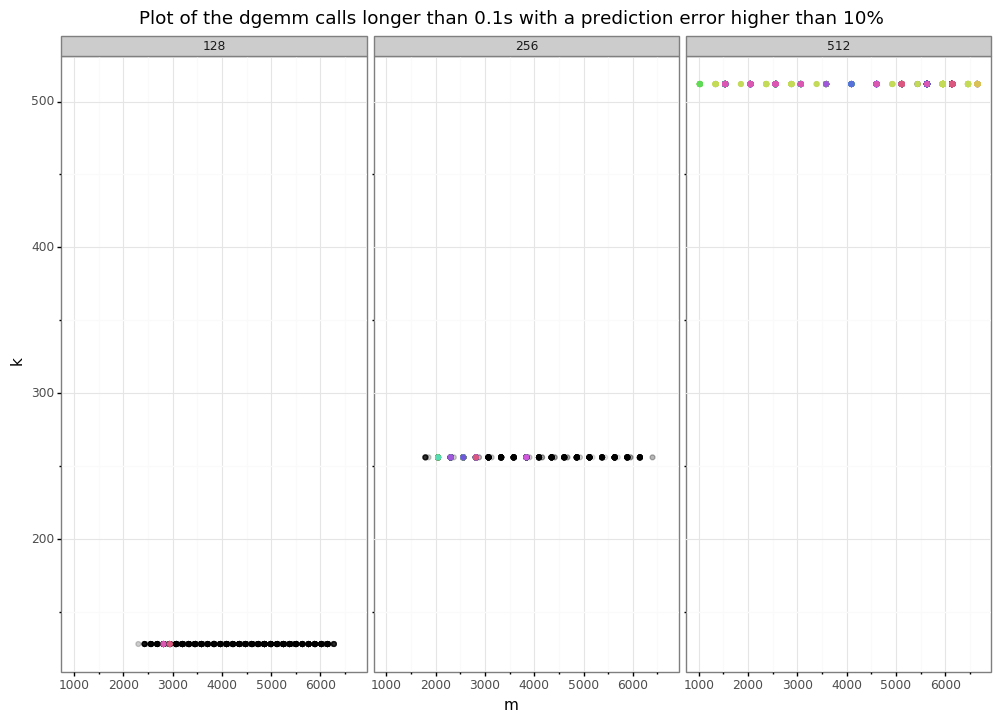

<ggplot: (-9223363274143101780)>


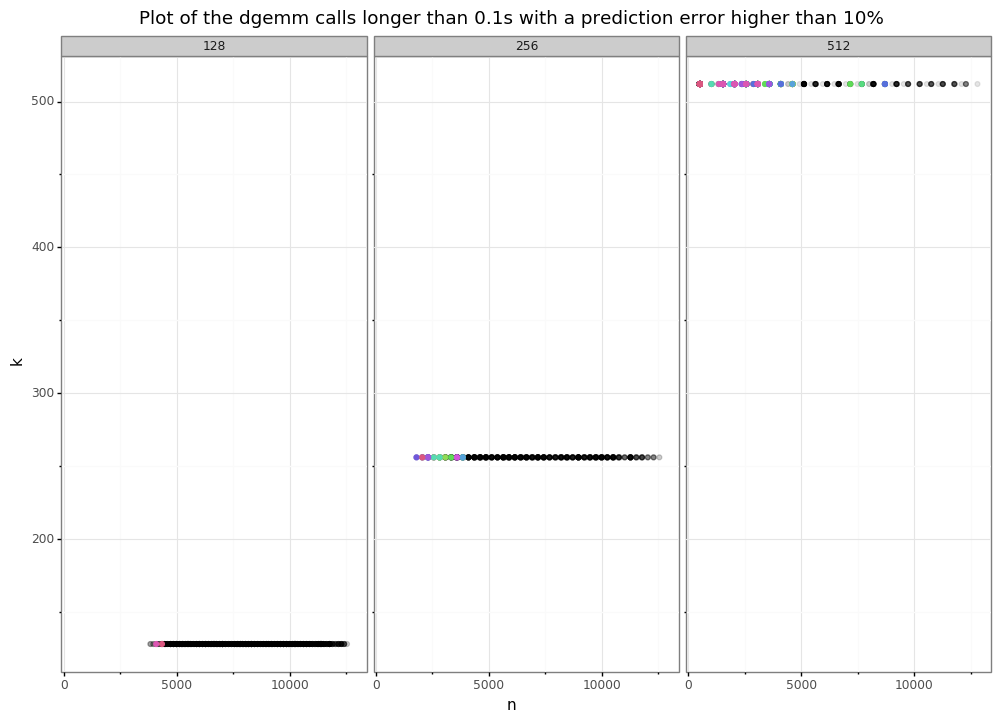

<ggplot: (8762673903571)>


In [13]:
p = ggplot(tmp, aes(color='factor(hostname)')) + theme_bw() + facet_wrap(['block_size'], ncol=3)
p = p + theme(legend_position='none') + ggtitle('Plot of the dgemm calls longer than 0.1s with a prediction error higher than 10%')
for x, y in ['mn', 'mk', 'nk']:
    print(p + geom_point(tmp_nonerror, aes(x=x, y=y), color='black', alpha=0.1) + geom_point(aes(x=x, y=y)))

In [14]:
summary = traces.groupby(['block_size', 'hostname', 'node', 'socket', 'cpu', 'rank'])[['duration', 'pred', 'mnk']].sum().reset_index()
summary['gflops_real'] = 2*summary['mnk'] / summary['duration'] * 1e-9
summary['gflops_pred'] = 2*summary['mnk'] / summary['pred'] * 1e-9
summary['error'] = (summary['pred'] - summary['duration']) / summary['duration']
summary['abs_error'] = summary['error'].abs()
summary.sort_values(by='abs_error', ascending=False).head(n=10)

,block_size,hostname,node,socket,cpu,rank,duration,pred,mnk,gflops_real,gflops_pred,error,abs_error
804,256,dahu-26.grenoble.grid5000.fr,26,0,50,292,374.871611,354.499279,5.089767e+12,27.154721,28.715246,-0.054345,0.054345
803,256,dahu-26.grenoble.grid5000.fr,26,0,50,291,373.762915,354.062967,5.080103e+12,27.183560,28.696044,-0.052707,0.052707
805,256,dahu-26.grenoble.grid5000.fr,26,0,50,293,375.421256,356.027778,5.099431e+12,27.166446,28.646251,-0.051658,0.051658
809,256,dahu-26.grenoble.grid5000.fr,26,0,50,297,376.519509,357.862202,5.138085e+12,27.292532,28.715440,-0.049552,0.049552
580,256,dahu-19.grenoble.grid5000.fr,19,0,36,68,385.206435,366.330064,5.268111e+12,27.352142,28.761552,-0.049003,0.049003
807,256,dahu-26.grenoble.grid5000.fr,26,0,50,295,375.189716,356.905424,5.118758e+12,27.286238,28.684114,-0.048733,0.048733
810,256,dahu-26.grenoble.grid5000.fr,26,0,50,298,376.956701,358.643549,5.147749e+12,27.312150,28.706770,-0.048582,0.048582
811,256,dahu-26.grenoble.grid5000.fr,26,0,50,299,378.441578,360.063036,5.157413e+12,27.256057,28.647276,-0.048564,0.048564
808,256,dahu-26.grenoble.grid5000.fr,26,0,50,296,375.419915,357.198122,5.128422e+12,27.320989,28.714718,-0.048537,0.048537
806,256,dahu-26.grenoble.grid5000.fr,26,0,50,294,375.362926,357.152377,5.109094e+12,27.222157,28.610165,-0.048515,0.048515


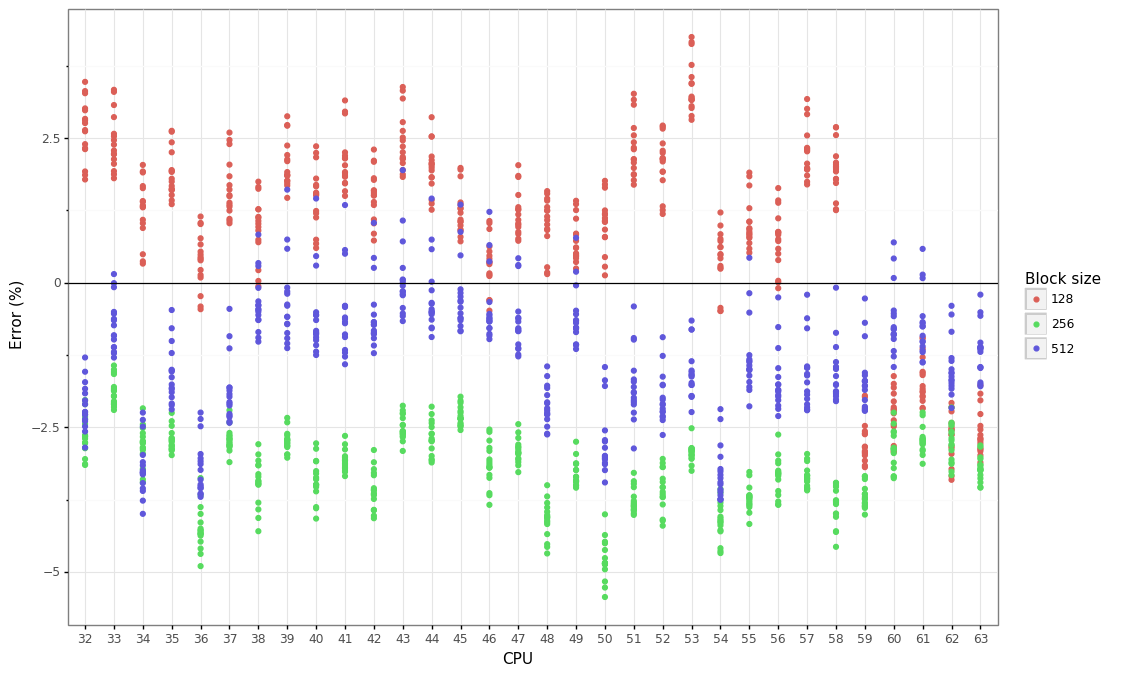

<ggplot: (-9223363274193076273)>

In [15]:
tmp = summary.copy()
tmp['error'] *= 100
plot = ggplot(tmp, aes(x='factor(cpu)', y='error', color='factor(block_size)')) + geom_point() + theme_bw()
plot = plot + geom_hline(yintercept=0) + ylab('Error (%)') + xlab('CPU') + labs(color='Block size')
plot

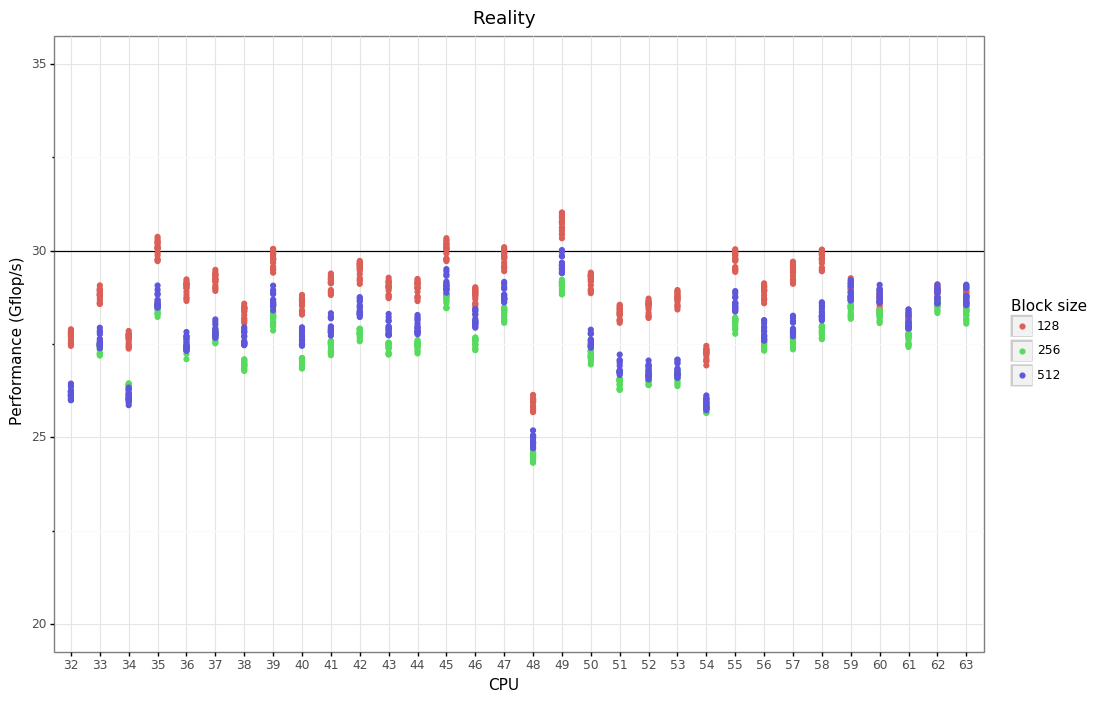

<ggplot: (-9223363274193158098)>


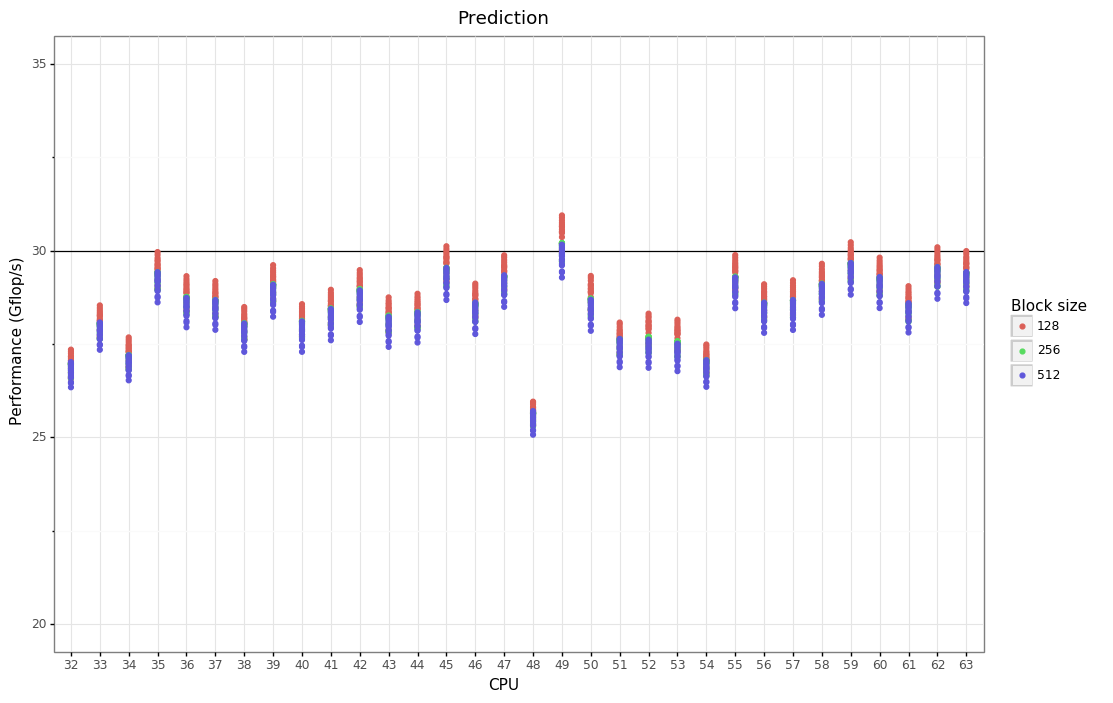

<ggplot: (8762661560079)>


In [16]:
plot = ggplot(tmp, aes(x='factor(cpu)', color='factor(block_size)')) + theme_bw()
plot = plot + geom_hline(yintercept=30) + ylab('Performance (Gflop/s)') + xlab('CPU') + labs(color='Block size') + expand_limits(y=20) + expand_limits(y=35)
print(plot + geom_point(aes(y='gflops_real')) + ggtitle('Reality'))
print(plot + geom_point(aes(y='gflops_pred')) + ggtitle('Prediction'))

## Monitoring

In [17]:
import cashew
print(cashew.__git_version__)
from cashew import archive_extraction

ca8a64e6735b60bc60c49342320befcdeaf55f90


In [18]:
base_time = pandas.to_datetime(get_yaml(archive, 'info.yaml')['timestamp']['setup']['start'])
base_time

Timestamp('2019-12-10 09:57:24.537598')

In [19]:
%time monitoring = archive_extraction.read_archive_csv(archive, 'monitoring.csv')
cluster = archive_extraction.read_yaml(archive, 'info.yaml')['cluster']
site = archive_extraction.read_yaml(archive, 'info.yaml')['site']
monitoring['node'] = monitoring['hostname'].str[len(cluster)+1:-(len(site)+len('..grid5000.fr'))].astype(int)
monitoring['timestamp'] = pandas.to_datetime(monitoring['timestamp'])
monitoring['start'] = monitoring['timestamp'] - base_time
print(len(monitoring))
monitoring.head()

CPU times: user 80.1 ms, sys: 12 ms, total: 92.1 ms
Wall time: 90.5 ms
7072


,hostname,timestamp,ctx_switches,interrupts,soft_interrupts,memory_available_percent,memory_available,temperature_core_0,temperature_core_1,temperature_core_2,...,bytes_sent_enp24s0f0,bytes_recv_enp24s0f0,bytes_sent_enp24s0f1,bytes_recv_enp24s0f1,bytes_sent_ib0,bytes_recv_ib0,bytes_sent_lo,bytes_recv_lo,node,start
0,dahu-17.grenoble.grid5000.fr,2019-12-10 10:02:44.312761,1610839,552530,441046,98.9,198985338880,49.0,39.0,51.0,...,883343,139357860,0,0,0,0,15822,15822,17,00:05:19.775163
1,dahu-17.grenoble.grid5000.fr,2019-12-10 10:02:49.322876,1634246,568171,467238,98.9,198962388992,48.0,39.0,50.0,...,933039,144476767,0,0,0,0,15822,15822,17,00:05:24.785278
2,dahu-17.grenoble.grid5000.fr,2019-12-10 10:02:54.335194,1668880,574066,474403,98.9,198971486208,49.0,39.0,50.0,...,1057494,171369883,0,0,0,0,15822,15822,17,00:05:29.797596
3,dahu-17.grenoble.grid5000.fr,2019-12-10 10:02:59.347066,1673223,579951,487987,98.6,198311317504,55.0,46.0,59.0,...,1124658,171379857,0,0,0,0,15822,15822,17,00:05:34.809468
4,dahu-17.grenoble.grid5000.fr,2019-12-10 10:03:04.364076,1712101,666545,684988,98.6,198440812544,59.0,50.0,62.0,...,1940258,171457859,0,0,0,0,15822,15822,17,00:05:39.826478


In [20]:
def my_melt(df, prefix, idcol):
    result = []
    columns = [col for col in df.columns if col.startswith(prefix)]
    for col in columns:
        tmp = df[idcol].copy()
        tmp[prefix] = df[col]
        tmp['group'] = int(col[len(prefix):])
        result.append(tmp)
    return pandas.concat(result)

In [21]:
platform = archive_extraction.get_platform(archive)
mapping = archive_extraction.platform_to_cpu_mapping(platform)

In [22]:
history = get_json(archive, 'history.json')
mpirun = [cmd for cmd in history if cmd['command'].startswith('mpirun') and len(cmd['hostnames']) == 1]
for cmd in mpirun:
    for key in ['start', 'stop']:
        cmd['date'][key] = pandas.to_datetime(cmd['date'][key]) - base_time
mpirun = pandas.DataFrame([cmd['date'] for cmd in mpirun])
mpirun['block_size'] = read_csv(archive, 'exp.csv')['block_size']
mpirun

,duration,start,stop,block_size
0,451.395006,00:16:13.774438,00:23:45.169444,128
1,497.674550,00:24:09.332379,00:32:27.006929,256
2,556.565561,00:32:43.008654,00:41:59.574215,512


In [23]:
plotnine.options.figure_size = (20, 12)

In [24]:
temperature = my_melt(monitoring, 'temperature_core_', ['hostname', 'start', 'node'])
temperature['cpu'] = temperature.apply(lambda row: mapping[row.group], axis=1)
print(len(temperature))
temperature.head()

226304


,hostname,start,node,temperature_core_,group,cpu
0,dahu-17.grenoble.grid5000.fr,00:05:19.775163,17,49.0,0,0
1,dahu-17.grenoble.grid5000.fr,00:05:24.785278,17,48.0,0,0
2,dahu-17.grenoble.grid5000.fr,00:05:29.797596,17,49.0,0,0
3,dahu-17.grenoble.grid5000.fr,00:05:34.809468,17,55.0,0,0
4,dahu-17.grenoble.grid5000.fr,00:05:39.826478,17,59.0,0,0


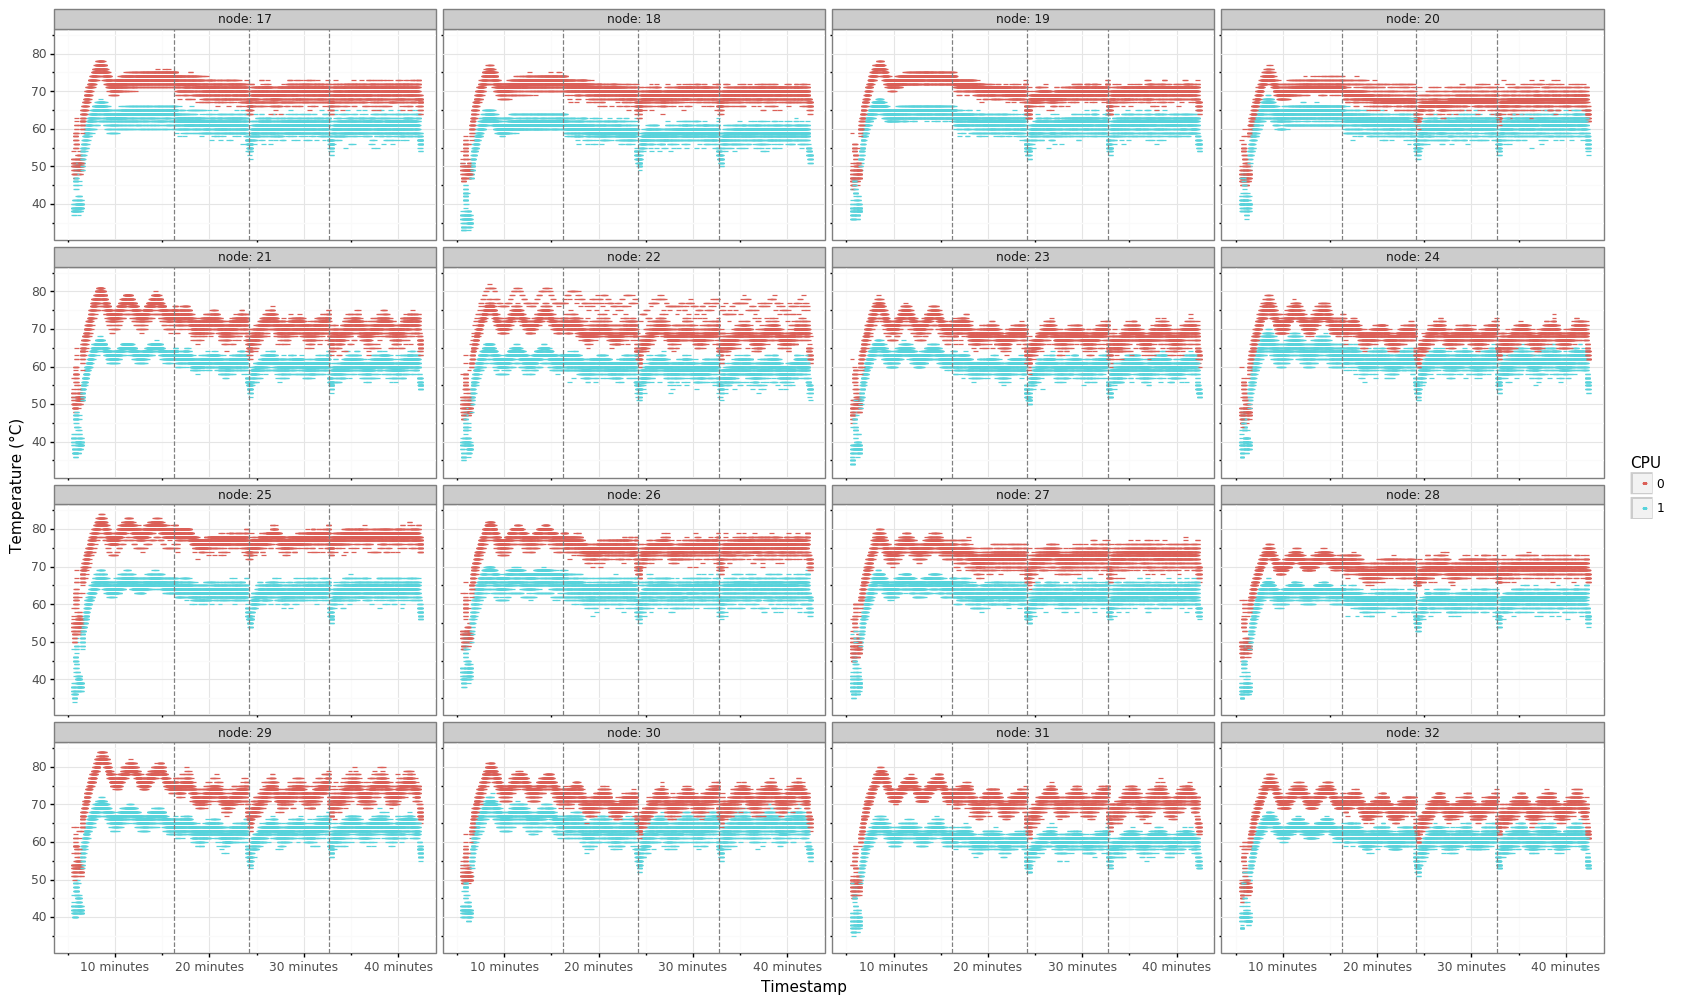

<ggplot: (-9223363274193250535)>

In [25]:
plot = ggplot(temperature, aes(x='start', y='temperature_core_', color='factor(cpu)')) + geom_point(shape=1)
plot = plot + facet_wrap('node', labeller='label_both') + theme_bw() + xlab('Timestamp') + ylab('Temperature (°C)') + labs(color='CPU')
for start in mpirun['start']:
    plot = plot + geom_vline(xintercept=start, color='grey', linetype='dashed')
plot

In [26]:
frequency = my_melt(monitoring, 'frequency_core_', ['hostname', 'start', 'node'])
frequency = frequency[frequency['group'] <= max(mapping.keys())]  # removing the cores with largest IDs (they are not real cores, just hyperthreads)
frequency['cpu'] = frequency.apply(lambda row: mapping[row.group], axis=1)
frequency['frequency_core_'] *= 1e-9
print(len(frequency))
frequency.head()

226304


,hostname,start,node,frequency_core_,group,cpu
0,dahu-17.grenoble.grid5000.fr,00:05:19.775163,17,3.035668,0,0
1,dahu-17.grenoble.grid5000.fr,00:05:24.785278,17,1.000012,0,0
2,dahu-17.grenoble.grid5000.fr,00:05:29.797596,17,1.000012,0,0
3,dahu-17.grenoble.grid5000.fr,00:05:34.809468,17,2.775476,0,0
4,dahu-17.grenoble.grid5000.fr,00:05:39.826478,17,3.074505,0,0


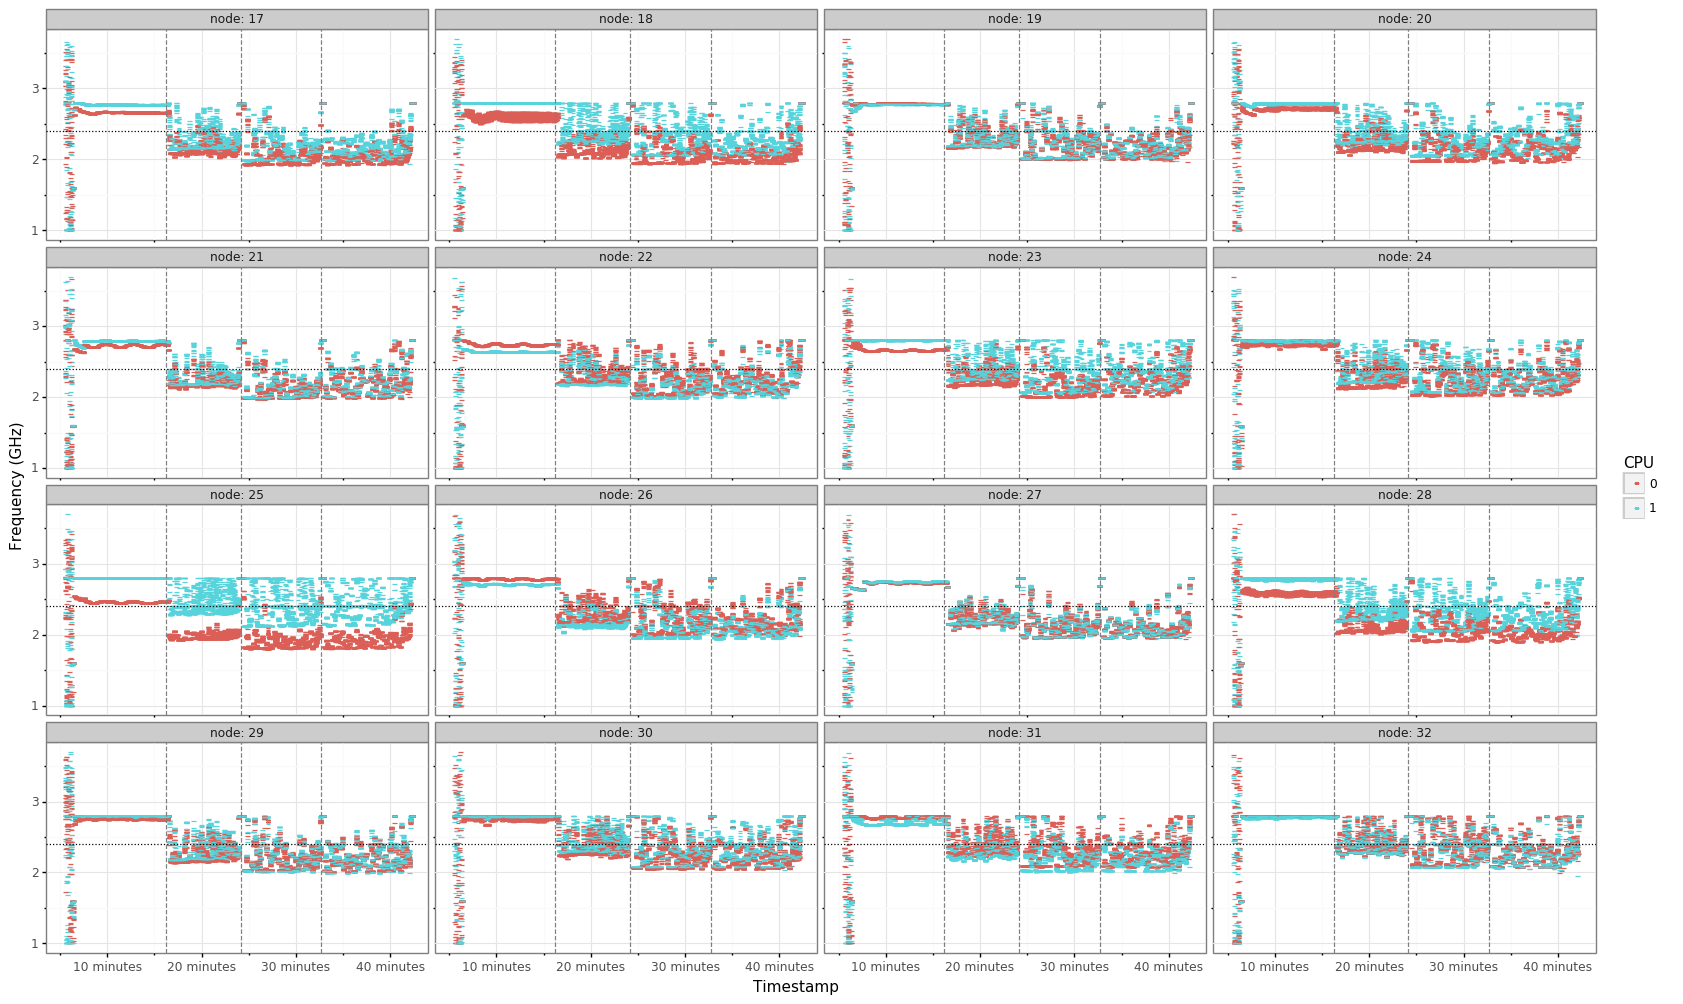

<ggplot: (-9223363274261861446)>

In [27]:
plot = ggplot(frequency, aes(x='start', y='frequency_core_', color='factor(cpu)')) + geom_point(shape=1)
plot = plot + facet_wrap('node', labeller='label_both') + theme_bw() + xlab('Timestamp') + ylab('Frequency (GHz)') + labs(color='CPU')
for start in mpirun['start']:
    plot = plot + geom_vline(xintercept=start, color='grey', linetype='dashed')
plot += geom_hline(yintercept = 2.4, linetype='dotted')
plot

In [28]:
frequency['block_size'] = 0
for _, row in mpirun.iterrows():
    frequency.loc[(frequency.start >= row.start) & (frequency.start <= row.stop), 'block_size'] = row.block_size
frequency.sample(n=10).sort_values(by='start')

,hostname,start,node,frequency_core_,group,cpu,block_size
1791,dahu-21.grenoble.grid5000.fr,00:07:15.023838,21,2.696649,5,1,0
24,dahu-17.grenoble.grid5000.fr,00:07:20.157370,17,2.672680,2,0,0
4558,dahu-27.grenoble.grid5000.fr,00:16:51.285724,27,2.156011,27,1,128
3710,dahu-25.grenoble.grid5000.fr,00:19:51.477591,25,2.412359,15,1,128
3712,dahu-25.grenoble.grid5000.fr,00:20:01.501582,25,2.313665,23,1,128
1549,dahu-20.grenoble.grid5000.fr,00:23:57.125648,20,2.799957,11,1,0
1563,dahu-20.grenoble.grid5000.fr,00:25:07.289696,20,2.172161,19,1,256
6005,dahu-30.grenoble.grid5000.fr,00:26:57.481383,30,2.238427,16,0,256
5261,dahu-28.grenoble.grid5000.fr,00:38:39.342931,28,2.135760,23,1,512
6178,dahu-30.grenoble.grid5000.fr,00:41:24.562179,30,2.566040,13,1,512


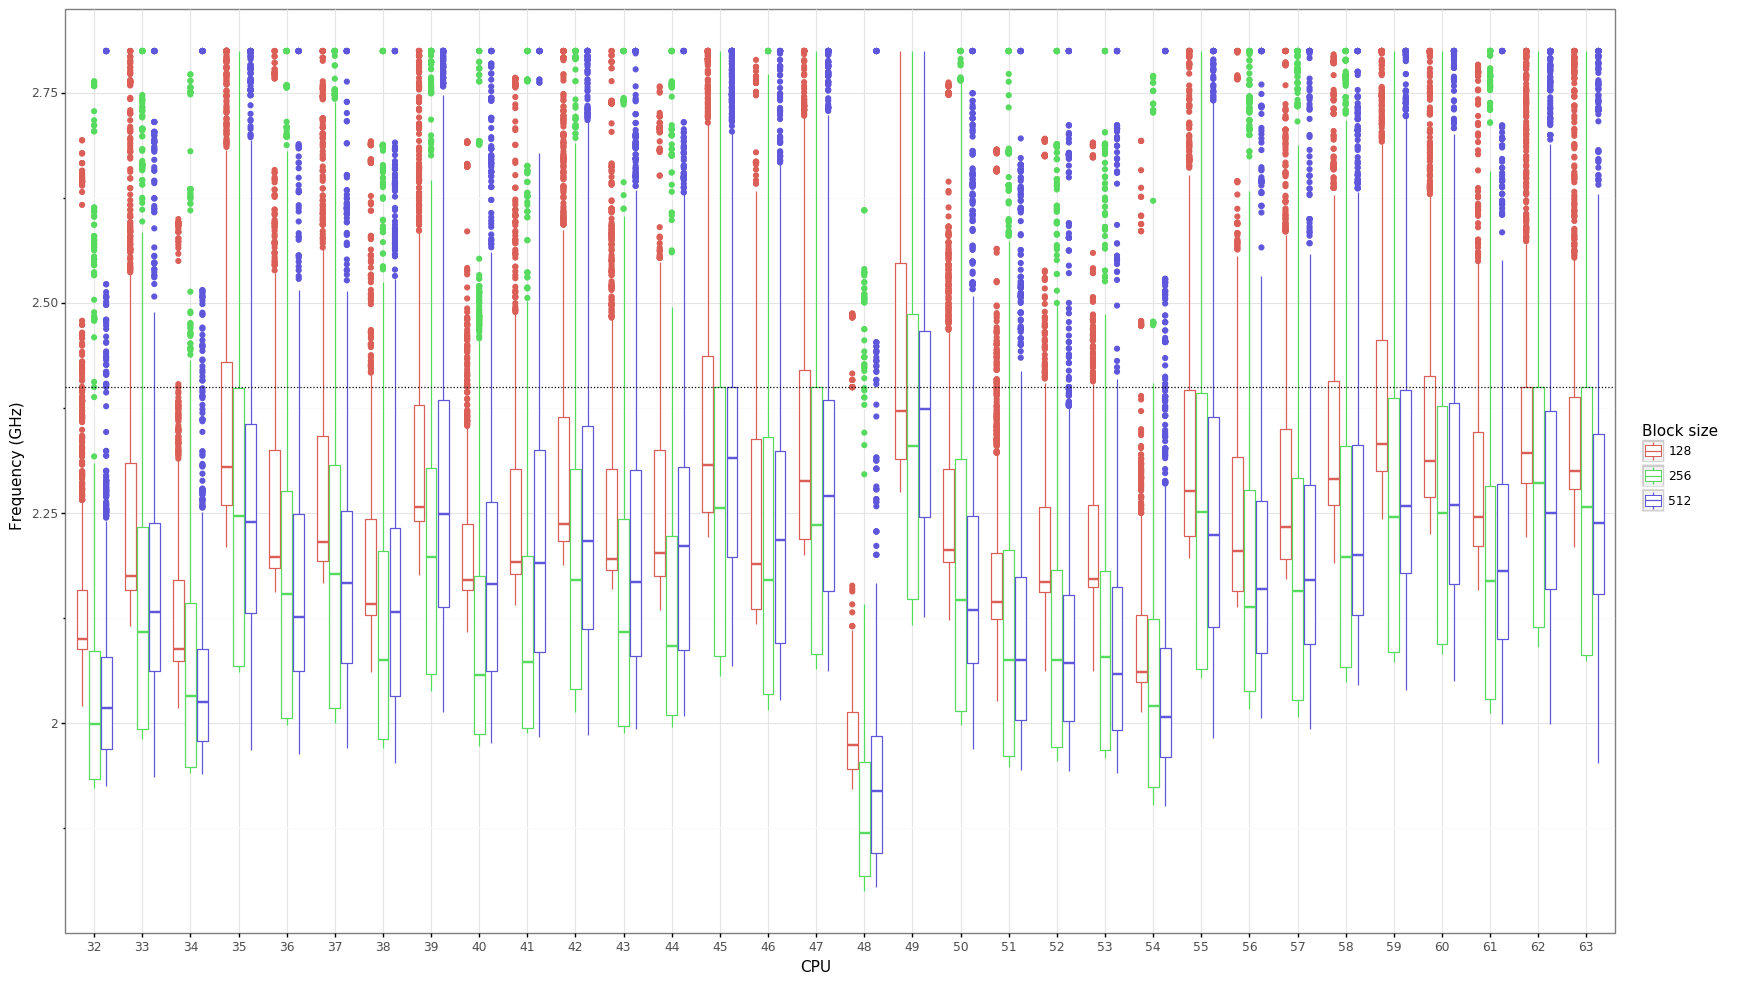

<ggplot: (8762664338040)>

In [30]:
frequency['cpu_id'] = frequency['node'] * 2 + frequency['cpu'] - 2
plot = ggplot(frequency[frequency.block_size != 0], aes(x='factor(cpu_id)', y='frequency_core_', color='factor(block_size)')) + geom_boxplot()
plot = plot + theme_bw() + xlab('CPU') + ylab('Frequency (GHz)') + labs(color='Block size')
plot += geom_hline(yintercept = 2.4, linetype='dotted')
plot